In [1]:
import pandas as pd
from quartic_sdk.model import BaseQuarticModel

In [ ]:
from quartic_sdk import APIClient
import os

client = APIClient(os.environ.get("QUARTIC_HOST"), username=os.environ.get("QUARTIC_USERNAME"), password=os.environ.get("QUARTIC_PASSWORD"))

In [3]:
assets=client.assets()
asset=assets.get("id",865)

In [4]:
from datetime import datetime
from pytz import timezone

stop_time = int(datetime.now().timestamp() * 1000) # get current time in millisec unix timestamp
start_time = stop_time - 30 * 60 * 1000 # timestamp 30 mins ago

# fetch chuncks of DataFrames and then concatenate them into a piece
asset_data_itr = asset.data(start_time=start_time, stop_time=stop_time)
df = pd.DataFrame()
for next_df in asset_data_itr:
    df = pd.concat([df, next_df])
    
df.head()

,39936,39937,39938,39939,39940,39941,39942,39943,39944,39945,...,39926,39927,39928,39929,39930,39931,39932,39933,39934,39935
1617464820000,7.708095,9.921607,14.35721,26.963070,34.865341,18.85195,6.865035,3.184749,46.595711,47.709621,...,21.295300,33.982220,1.964027,20.877590,26.918249,30.172239,31.197451,14.201760,21.666290,14.69863
1617464880000,7.890249,11.427480,14.67098,26.824789,35.263031,14.75204,6.573205,3.426986,46.729229,47.709621,...,18.649771,33.896389,1.904898,21.067369,26.187719,30.494579,31.009569,16.119631,20.076490,14.49168
1617464940000,7.829214,11.181430,14.79305,27.312120,34.450489,14.02914,6.416800,3.252461,47.219421,47.709621,...,20.744070,34.079498,2.341688,21.086439,28.200010,30.642401,31.288050,15.985160,22.822149,14.85886
1617465000000,6.871710,12.302010,15.85641,28.347830,35.131409,16.19879,6.280423,3.222897,46.626221,47.709621,...,19.446100,33.327030,2.058442,21.481270,26.261160,28.756010,31.410120,15.816360,22.015341,15.35096
1617465060000,7.830167,11.274890,14.30571,27.967310,34.544899,13.68486,5.900855,3.070306,46.909470,47.709621,...,18.414209,33.356602,2.159533,21.466009,27.799459,29.386400,30.825510,14.980930,22.894640,13.63336


In [5]:
df = df.dropna(axis=1)

In [6]:
target_col = "39942"
feature_cols = ["39936", "39937", "39938", "39939", "39940", "39941"]

In [12]:
# Data Characteristics
print("Shape : ", df.shape)
print("\n", df[feature_cols].describe())

Shape :  (30, 93)

            39936      39937      39938      39939      39940      39941
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000
mean    7.595465  10.840486  14.436656  27.598325  34.877958  14.693388
std     0.474186   0.911441   0.634920   0.697353   0.491044   1.336826
min     6.694324   9.719425  13.385410  26.597811  33.928810  12.480350
25%     7.308023  10.080872  13.927575  27.140700  34.528927  13.847467
50%     7.598421  10.611120  14.326215  27.392705  34.908257  14.591820
75%     7.909562  11.267500  14.857905  27.946090  35.195310  15.553375
max     8.581675  13.730640  15.856410  29.204241  36.381699  18.851950


In [8]:
df_X = df[feature_cols]
df_y = df[[target_col]]
X = df_X.to_numpy()
y = df_y.to_numpy()
y = y.reshape(-1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Root Mean Squared Error :  0.3256757261316937
Mean Absolute Error :  0.10606467859140595


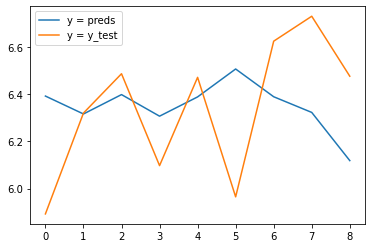

In [10]:
# apply processed data to a Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor().fit(X_train, y_train)
preds = reg.predict(X_test)

import matplotlib.pyplot as plt
plt.plot(preds)
plt.plot(y_test)
plt.legend(['y = preds', 'y = y_test'])

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
print("Root Mean Squared Error : ", math.sqrt(mean_squared_error(y_test, preds)))
print("Mean Absolute Error : ", mean_squared_error(y_test, preds))

In [ ]:
from quartic_sdk.model import BaseQuarticModel

class RandomForestRegressionModel(BaseQuarticModel):
    def __init__(self, name, description, model):
        self.model = model
        super().__init__(name=name, description=description)
        
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_predict):
        predictions = self.model.predict(X_predict)
        return pd.Series(predictions)


RF_regressor_model = RandomForestRegressionModel(name="Random_Forest_Regressor",
                                     description="Simple model using Random Forest Regression",
                                     model=reg)

RF_regressor_model.train(X_train, y_train) # Training data extracted from data loaded from the Quartic AI Platform
RF_regressor_model.save(client=client, output_tag_name= f"Prediction Result of {target_col}",
                   feature_tags=feature_cols, # tags that are used in the X variable or features
                   target_tag = target_col, # tag that specifies a relationship for prediction
                   test_df = df_X
                   )
